## Installs

In [1]:
!apt-get update && apt-get install -y libsndfile1 ffmpeg
!pip install Cython packaging
!pip install nemo_toolkit['asr']
!pip install megatron-core

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,200 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,599 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,518 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,645 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [3,663 kB]
Hit:13 https://ppa.launchpad

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.9 MB/s eta 0:00:00


## Imports

In [2]:
import numpy as np
import os
import nemo
import nemo.collections.asr as nemo_asr
from nemo import lightning as nl

## Clone jeli-data-manifest Hugging Face

Clone the HF git repo holding the data for the Nemo compatible version of Jeli-ASR

In [3]:
# Clone dataset repository with directory structure
# This will take about 14 minutes
!git clone --depth 1 https://huggingface.co/datasets/RobotsMali/jeli-asr

Cloning into 'jeli-asr'...
remote: Enumerating objects: 29425, done.
remote: Counting objects: 100% (29425/29425), done.
remote: Compressing objects: 100% (29419/29419), done.
remote: Total 29425 (delta 8), reused 29411 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (29425/29425), 7.86 MiB | 13.48 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Updating files: 100% (33663/33663), done.
Filtering content: 100% (33572/33572), 4.26 GiB | 5.28 MiB/s, done.


In [4]:
!rm -rf jeli-asr/.git

In [7]:
!ls jeli-asr

bam-asr-oza	  jeli-asr.py	 manifests     README.md
french-manifests  jeli-asr-rmai  metadata.csv  scripts


In [6]:
import IPython.display as ipd
import librosa

# Load and listen to the audio file
example_file = 'jeli-asr/bam-asr-oza/train/split1/oza75-bam-asr-0.wav'
audio, sample_rate = librosa.load(example_file)

ipd.Audio(example_file, rate=sample_rate)

Let's plot the waveform, which is simply a line plot of the sequence of values that we read from the file. This is a format of viewing audio that you are likely to be familiar with seeing in many audio editors and visualizers:

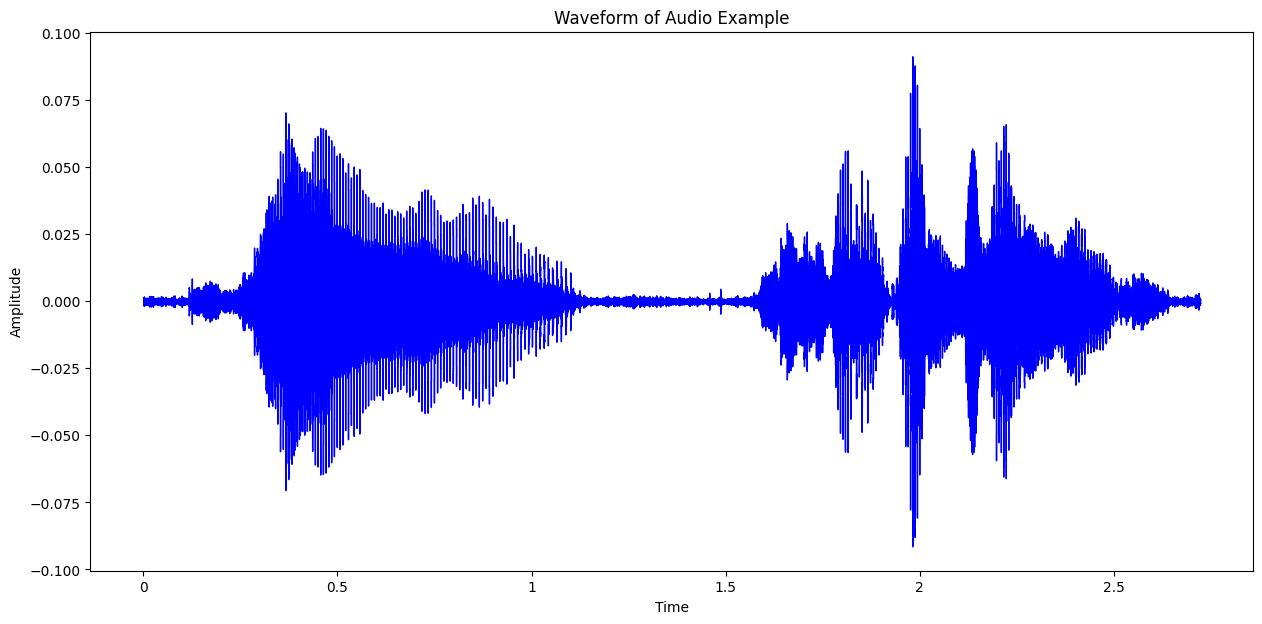

In [8]:
%matplotlib inline
import librosa.display
import matplotlib.pyplot as plt

# Plot our example audio file's waveform
plt.rcParams['figure.figsize'] = (15,7)
plt.title('Waveform of Audio Example')
plt.ylabel('Amplitude')

_ = librosa.display.waveshow(audio, color='blue')

### Spectrograms and Mel Spectrograms

However, since audio information is more useful in the context of frequencies of sound over time, we can get a better representation than this raw sequence of 57,330 values.
We can apply a [Fourier Transform](https://en.wikipedia.org/wiki/Fourier_transform) on our audio signal to get something more useful: a **spectrogram**, which is a representation of the energy levels (i.e. amplitude, or "loudness") of each frequency (i.e. pitch) of the signal over the duration of the file.
A spectrogram (which can be viewed as a heat map) is a good way of seeing how the *strengths of various frequencies in the audio vary over time*, and is obtained by breaking up the signal into smaller, usually overlapping chunks and performing a Short-Time Fourier Transform (STFT) on each.

Let's examine what the spectrogram of our sample looks like.

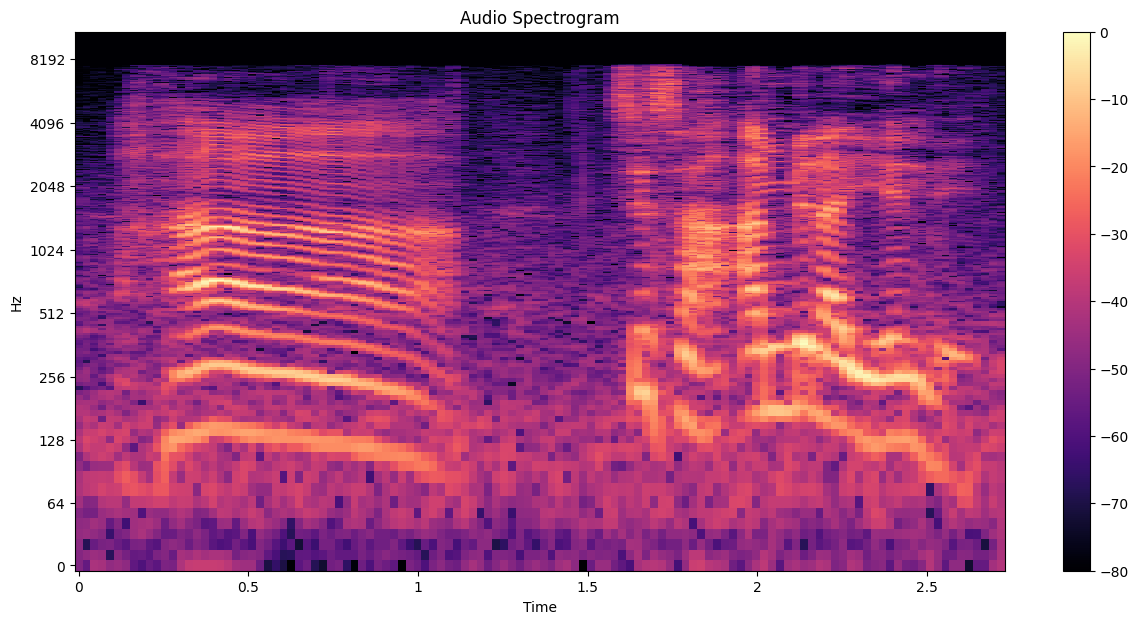

In [9]:
# Get spectrogram using Librosa's Short-Time Fourier Transform (stft)
spec = np.abs(librosa.stft(audio))
spec_db = librosa.amplitude_to_db(spec, ref=np.max)  # Decibels

# Use log scale to view frequencies
librosa.display.specshow(spec_db, y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Audio Spectrogram');

## Using a pretrained Models in NeMo hub

In [10]:
list_of_available_models = nemo_asr.models.EncDecCTCModel.list_available_models()
list_of_available_models[:3]

[PretrainedModelInfo(
 	pretrained_model_name=QuartzNet15x5Base-En,
 	description=QuartzNet15x5 model trained on six datasets: LibriSpeech, Mozilla Common Voice                 (validated clips from en_1488h_2019-12-10), WSJ, Fisher, Switchboard, and NSC Singapore English.                     It was trained with Apex/Amp optimization level O1 for 600 epochs. The model achieves a WER of                     3.79% on LibriSpeech dev-clean, and a WER of 10.05% on dev-other. Please visit                         https://ngc.nvidia.com/catalog/models/nvidia:nemospeechmodels for further details.,
 	location=https://api.ngc.nvidia.com/v2/models/nvidia/nemospeechmodels/versions/1.0.0a5/files/QuartzNet15x5Base-En.nemo
 ),
 PretrainedModelInfo(
 	pretrained_model_name=stt_en_quartznet15x5,
 	description=For details about this model, please visit https://ngc.nvidia.com/catalog/models/nvidia:nemo:stt_en_quartznet15x5,
 	location=https://api.ngc.nvidia.com/v2/models/nvidia/nemo/stt_en_quartznet15x5/v

In [11]:
# This line will download pre-trained QuartzNet15x5 model from NVIDIA's NGC cloud and instantiate it for you
quartznet = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="QuartzNet15x5Base-En")

[NeMo I 2025-01-14 14:03:46 cloud:68] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemospeechmodels/versions/1.0.0a5/files/QuartzNet15x5Base-En.nemo to /root/.cache/torch/NeMo/NeMo_2.1.0/QuartzNet15x5Base-En/b69977d31abaf2ab3e8f082866f6dfcb/QuartzNet15x5Base-En.nemo
[NeMo I 2025-01-14 14:03:48 common:826] Instantiating model from pre-trained checkpoint
[NeMo I 2025-01-14 14:03:49 features:305] PADDING: 16
[NeMo I 2025-01-14 14:03:50 save_restore_connector:275] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_2.1.0/QuartzNet15x5Base-En/b69977d31abaf2ab3e8f082866f6dfcb/QuartzNet15x5Base-En.nemo.


Note that attempting to transcribe Bambara without fine tuning or changing Vocab will fail. This will result in a shape mismatch error from the encoder

In [12]:
# Get an english audio sample to test QuartzNet15x5Base-En
!wget -O sample_english_audio.wav "http://www.voiptroubleshooter.com/open_speech/american/OSR_us_000_0010_8k.wav"

--2025-01-14 14:03:55--  http://www.voiptroubleshooter.com/open_speech/american/OSR_us_000_0010_8k.wav
Resolving www.voiptroubleshooter.com (www.voiptroubleshooter.com)... 162.241.218.124
Connecting to www.voiptroubleshooter.com (www.voiptroubleshooter.com)|162.241.218.124|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 538014 (525K) [audio/x-wav]
Saving to: ‘sample_english_audio.wav’

sample_english_audi 100%[===================>] 525.40K  --.-KB/s    in 0.1s    

2025-01-14 14:03:56 (4.48 MB/s) - ‘sample_english_audio.wav’ saved [538014/538014]



In [15]:
ipd.Audio('sample_english_audio.wav', autoplay=True)

In [16]:
transcription = quartznet.transcribe(audio='sample_english_audio.wav')
transcription

Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.23it/s]


['the birch canoe slid on the smooth planks glue the sheat to the dark blue background it is easy to tell the depth over well these days a chicken legg ey raredish rice is often served in roundbowls the juice of lemons makes fine punch the box was done beside the park truck the hogs ere fed chopped corn and garbage four hours of study work faced us a large size in stockings is hard to sell']

## Data Augmentation

There exist several ASR data augmentation methods that can increase the size of our training set.

For example, we can perform augmentation on the spectrograms by zeroing out specific frequency segments ("frequency masking") or time segments ("time masking") as described by [SpecAugment](https://arxiv.org/abs/1904.08779), or zero out rectangles on the spectrogram as in [Cutout](https://arxiv.org/pdf/1708.04552.pdf). In NeMo, we can do all three of these by simply adding in a `SpectrogramAugmentation` neural module. (As of now, it does not perform the time warping from the SpecAugment paper.)

The quartznet model we got from cloud implement that feature:

In [17]:
print(quartznet._cfg['spec_augment'])

{'_target_': 'nemo.collections.asr.modules.SpectrogramAugmentation', 'rect_freq': 50, 'rect_masks': 5, 'rect_time': 120}


### Transfer learning with Nemo

Transfer learning with NeMo is simple. Let's demonstrate how the model we got from the cloud could be fine-tuned on jeli-asr data.

In [18]:
# Check what kind of vocabulary/alphabet the model has right now
print(quartznet.decoder.vocabulary)
new_vocab = ['l', 'ê', '̌', 'a', 'p', 'x', 'b', 'ç', 'k', 'ɔ', 's', 'r', 'h',
              'ɲ', 'q', 'z', 'f', 'c', 'n', 'g', 'j', 't', 'o', 'u', 'e', 'd',
              'ŋ', 'w', 'v', 'ɛ', 'm', 'y', "'", 'i']
# Note that you can (and should!) change the vocabulary
# entirely when fine-tuning using a different language.
quartznet.change_vocabulary(
    new_vocabulary=new_vocab
)

[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"]
[NeMo I 2025-01-14 14:05:37 ctc_models:263] Changed decoder to output to ['l', 'ê', '̌', 'a', 'p', 'x', 'b', 'ç', 'k', 'ɔ', 's', 'r', 'h', 'ɲ', 'q', 'z', 'f', 'c', 'n', 'g', 'j', 't', 'o', 'u', 'e', 'd', 'ŋ', 'w', 'v', 'ɛ', 'm', 'y', "'", 'i'] vocabulary.


After this, our decoder has completely changed, but our encoder (which is where most of the weights are) remained intact. Let's fine tune this model for 20 epochs on jeli-asr dataset.

In [23]:
!ls jeli-asr/manifests

jeli-asr-rmai-test-manifest.json   oza-bam-asr-test-manifest.json   test-manifest.json
jeli-asr-rmai-train-manifest.json  oza-bam-asr-train-manifest.json  train-manifest.json


Note that you might need to apply other preprocessing steps with another dataset. I filtered and modified jeli-asr to run smothly with nemo. You might also want to apply your own preprocessing strategy but no further

Nemo used to use yaml files for models and optimizers configuration. They changed for a programmatical approach in Nemo 2.0 (which I'm currently using) but you can still use yaml files are archives to save for traning parameter. I'm unsure of it but it also seems that the yaml config is still supported for ASR in this early version of Nemo 2.0

In [24]:
# Define Training and validation dataloaders' configs
train_data_config = {
    'manifest_filepath': 'jeli-asr/manifests/train-manifest.json',
    'sample_rate': 16000,
    'max_duration': 45,
    'min_duration': 1,
    'num_workers': 0,
    'shuffle': True,
    'batch_size': 8,
    'labels': new_vocab
}

valid_data_config = {
    'manifest_filepath': 'jeli-asr/manifests/test-manifest.json',
    'sample_rate': 16000,
    'max_duration': 45,
    'min_duration': 1,
    'num_workers': 0,
    'shuffle': False,
    'batch_size': 8,
    'labels': new_vocab
}

# Define the parameters for the optimizer
optim_config = {
    'name': 'novograd',
    'lr': 0.01,
    'betas': [0.8, 0.5],
    'weight_decay': 0.001,
    'sched': {
        'name': 'CosineAnnealing',
        'monitor': 'val_loss',
        'reduce_on_plateau': False,
        'warmup_steps': None,
        'warmup_ratio': None,
        'min_lr': 0.0,
        'last_epoch': -1,
    },
}

# Define the preprocessor
preprocessor_cfg = {
    '_target_': 'nemo.collections.asr.modules.AudioToMelSpectrogramPreprocessor',
    'sample_rate': 16000,
    'window_size': 0.02,
    'window_stride': 0.01,
    'window': 'hann',
    'features': 80,
    'n_fft': 512,
    'log': True,
    'normalize': 'per_feature',
}

In [25]:
# Use the smaller learning rate we set before
quartznet.setup_optimization(optim_config=optim_config)

# Point to the data we'll use for fine-tuning as the training set
quartznet.setup_training_data(train_data_config=train_data_config)

# Point to the new validation data for fine-tuning
quartznet.setup_validation_data(val_data_config=valid_data_config)

[NeMo W 2025-01-14 14:08:25 modelPT:672] Trainer wasn't specified in model constructor. Make sure that you really wanted it.


[NeMo I 2025-01-14 14:08:25 modelPT:793] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.01
        weight_decay: 0.001
    )


[NeMo W 2025-01-14 14:08:25 lr_scheduler:928] Neither `max_steps` nor `iters_per_batch` were provided to `optim.sched`, cannot compute effective `max_steps` !
    Scheduler will not be instantiated !


[NeMo I 2025-01-14 14:08:26 audio_to_text_dataset:49] Model level config does not contain `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2025-01-14 14:08:26 audio_to_text_dataset:49] Model level config does not contain `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2025-01-14 14:08:27 collections:197] Dataset loaded with 31284 files totalling 30.69 hours
[NeMo I 2025-01-14 14:08:27 collections:198] 896 files were filtered totalling 0.34 hours
[NeMo I 2025-01-14 14:08:27 audio_to_text_dataset:49] Model level config does not contain `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2025-01-14 14:08:27 audio_to_text_dataset:49] Model level config does not contain `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2025-01-14 14:08:27 collections:197] Dataset loaded with 1431 files totalling 1.44 hours
[NeMo I 2025-01-14 14:08:27 collections:198] 32 files were filtered totall

### Training with PyTorch Lightning

NeMo models and modules can be used in any PyTorch code where torch.nn.Module is expected.

However, NeMo's models are based on [PytorchLightning's](https://github.com/PyTorchLightning/pytorch-lightning) LightningModule and we recommend you use PytorchLightning for training and fine-tuning as it makes using mixed precision and distributed training very easy. So to start, let's create Trainer instance for training on GPU for 50 epochs

In [27]:
# Define a Pytorch lighthing trainer object
trainer = nl.Trainer(
    devices=1,
    accelerator='gpu',
    max_epochs=20,
    # This is very likely the max value of accumulated gradients for this dataset (with 'max_duration': 45) on Colab, without running out of gpu memory
    accumulate_grad_batches=8,
    check_val_every_n_epoch=1,
    logger=True,
    enable_progress_bar=True
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(quartznet)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[NeMo I 2025-01-14 14:09:57 modelPT:793] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.01
        weight_decay: 0.001
    )
[NeMo I 2025-01-14 14:09:57 lr_scheduler:948] Scheduler "<nemo.core.optim.lr_scheduler.CosineAnnealing object at 0x7a7779702f50>" 
    will be used during training (effective maximum steps = 9780) - 
    Parameters : 
    (warmup_steps: null
    warmup_ratio: null
    min_lr: 0.0
    last_epoch: -1
    max_steps: 9780
    )


INFO: 
  | Name              | Type                              | Params | Mode 
--------------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0      | train
1 | encoder           | ConvASREncoder                    | 18.9 M | train
2 | spec_augmentation | SpectrogramAugmentation           | 0      | train
3 | wer               | WER                               | 0      | train
4 | decoder           | ConvASRDecoder                    | 35.9 K | train
5 | loss              | CTCLoss                           | 0      | train
--------------------------------------------------------------------------------
18.9 M    Trainable params
0         Non-trainable params
18.9 M    Total params
75.722    Total estimated model params size (MB)
607       Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name              | Type                              | Param

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
!ls lightning_logs/

version_0  version_1


In [ ]:
# Show validation metrics
trainer.logged_metrics

{'train_loss': tensor(183.6356),
 'learning_rate': tensor(6.3982e-08),
 'global_step': tensor(621.),
 'training_batch_wer': tensor(1.),
 'val_loss': tensor(149.9999),
 'val_wer': tensor(1.)}

## Inferencing

In [ ]:
display(Audio('jeli-asr/jeli-asr-rmai/test/griots_r10-1052382-1061140.wav', autoplay=True))

In [ ]:
quartznet.transcribe(["jeli-asr/jeli-asr-rmai/test/griots_r10-1052382-1061140.wav",])

Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


['a']

## Saving a model and restoring a model

In [ ]:
# Save the trained model as a .nemo archive
quartznet.save_to('quartznet-finetuned-jeli.nemo')

# Note: you can also push your trained models to Hugging Face

To restore a model from an archive simply:

```
# Restore a model from an archive
model = nemo_asr.models.<MODEL_BASE_CLASS>.restore_from(restore_path="<path/to/checkpoint/file.nemo>")
```

Where the model base class is the ASR model class of the original checkpoint such as EncDecCTCModel, or the general ASRModel class.

Note that this is a different method than "EncDecCTCModel.from_pretrained" which is used to load checkpoints from Nemo NGC or Hugging Face
